In [1]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
#La latitud y longitud quiere decir que es ECUADOR
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": -1.25, 
	"longitude": -78.25,
	"daily": "daylight_duration",
	"hourly": ["rain", "visibility", "soil_moisture_1_to_3cm", "wind_gusts_10m", "is_day", "shortwave_radiation", "temperature_1000hPa"],
	"current": "rain",
	"timezone": "America/Guayaquil",# Ecuador timezone
	"forecast_days": 14,
	"cell_selection": "sea"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Current values. The order of variables needs to be the same as requested.
current = response.Current()
current_rain = current.Variables(0).Value()

print(f"Current time {current.Time()}")
print(f"Current rain {current_rain}")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_rain = hourly.Variables(0).ValuesAsNumpy()
hourly_visibility = hourly.Variables(1).ValuesAsNumpy()
hourly_soil_moisture_1_to_3cm = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_is_day = hourly.Variables(4).ValuesAsNumpy()
hourly_shortwave_radiation = hourly.Variables(5).ValuesAsNumpy()
hourly_temperature_1000hPa = hourly.Variables(6).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["rain"] = hourly_rain
hourly_data["visibility"] = hourly_visibility
hourly_data["soil_moisture_1_to_3cm"] = hourly_soil_moisture_1_to_3cm
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
hourly_data["is_day"] = hourly_is_day
hourly_data["shortwave_radiation"] = hourly_shortwave_radiation
hourly_data["temperature_1000hPa"] = hourly_temperature_1000hPa

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_daylight_duration = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["daylight_duration"] = daily_daylight_duration

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)


Coordinates -1.25°N -78.25°E
Elevation 3050.0 m asl
Timezone b'America/Guayaquil'b'GMT-5'
Timezone difference to GMT+0 -18000 s
Current time 1744484400
Current rain 0.0
                         date  rain  visibility  soil_moisture_1_to_3cm  \
0   2025-04-12 05:00:00+00:00   0.0     24140.0                   0.318   
1   2025-04-12 06:00:00+00:00   0.0     23540.0                   0.317   
2   2025-04-12 07:00:00+00:00   0.0     24140.0                   0.316   
3   2025-04-12 08:00:00+00:00   0.0     24140.0                   0.315   
4   2025-04-12 09:00:00+00:00   0.0     24140.0                   0.315   
..                        ...   ...         ...                     ...   
331 2025-04-26 00:00:00+00:00   0.2       200.0                     NaN   
332 2025-04-26 01:00:00+00:00   0.2      6100.0                     NaN   
333 2025-04-26 02:00:00+00:00   0.2     12020.0                     NaN   
334 2025-04-26 03:00:00+00:00   0.2     17920.0                     NaN   
335 20

C:\Users\Patricio\AppData\Local\Temp\ipykernel_2756\903879381.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


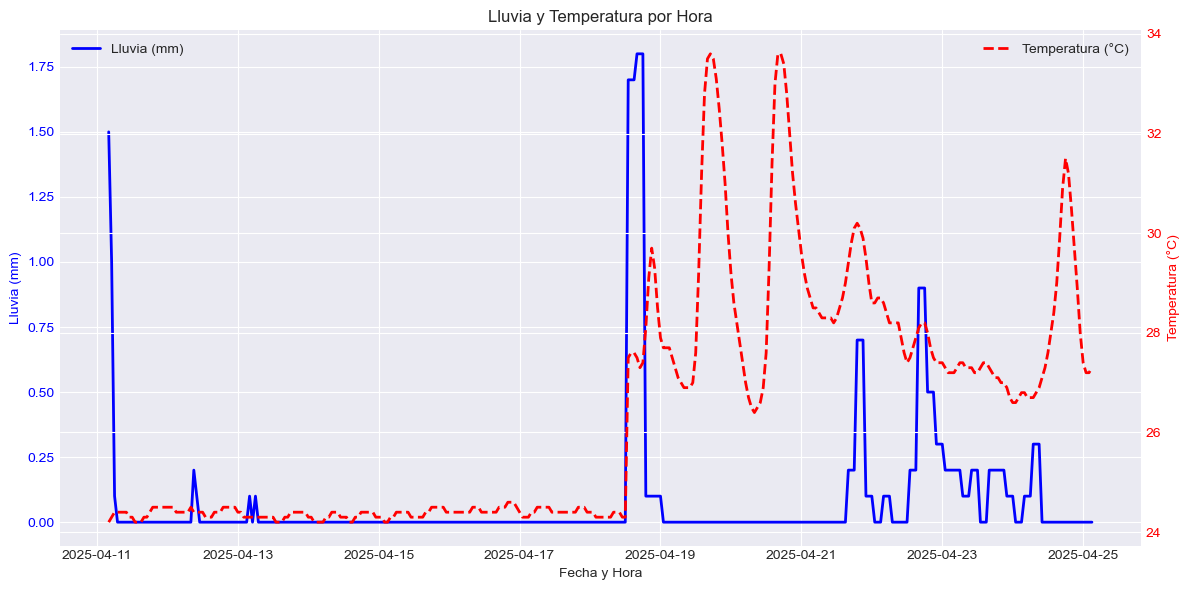

In [4]:
import matplotlib.pyplot as plt

# Configurar estilo del gráfico
plt.style.use('seaborn-darkgrid')

# Crear figura y ejes para ejes duales
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de lluvia
ax1.plot(hourly_dataframe['date'], hourly_dataframe['rain'], label="Lluvia (mm)", color='blue', linewidth=2)
ax1.set_xlabel("Fecha y Hora")
ax1.set_ylabel("Lluvia (mm)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear un segundo eje y para temperatura
ax2 = ax1.twinx()
ax2.plot(hourly_dataframe['date'], hourly_dataframe['temperature_1000hPa'], label="Temperatura (°C)", color='red', linewidth=2, linestyle='--')
ax2.set_ylabel("Temperatura (°C)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Añadir título, leyenda y formato final
plt.title("Lluvia y Temperatura por Hora")
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

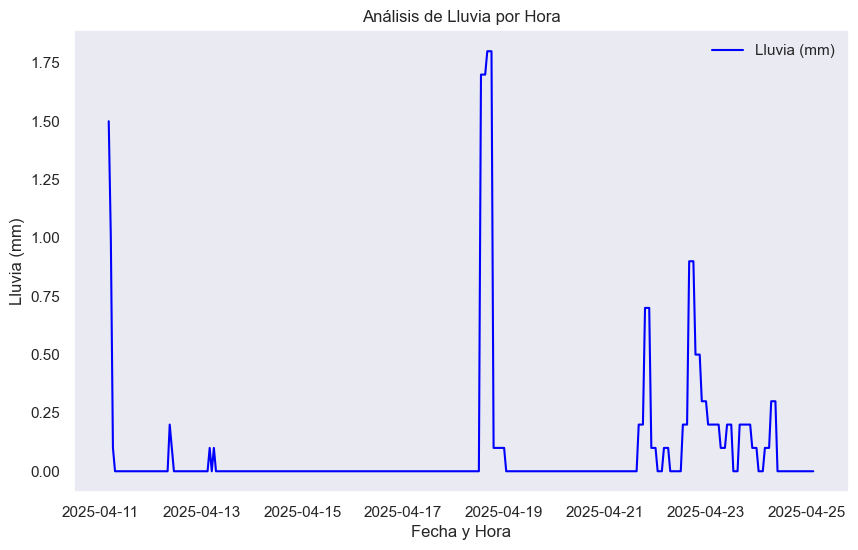

In [5]:
import seaborn as sns
sns.set_theme(style="darkgrid")  # Configura el estilo "darkgrid" de Seaborn

# Luego, continúas con tu gráfico normalmente
plt.figure(figsize=(10, 6))
plt.plot(hourly_dataframe['date'], hourly_dataframe['rain'], label="Lluvia (mm)", color='blue')
plt.xlabel("Fecha y Hora")
plt.ylabel("Lluvia (mm)")
plt.title("Análisis de Lluvia por Hora")
plt.legend()
plt.grid()
plt.show()

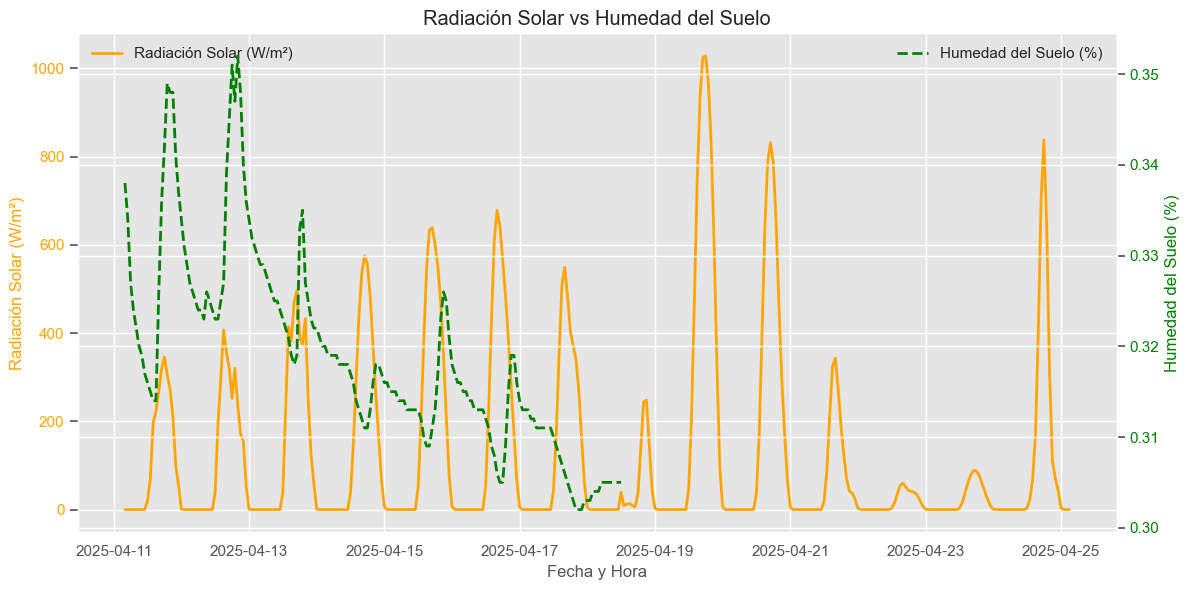

In [ ]:
# Configurar estilo del gráfico
plt.style.use('ggplot')

# Crear figura y ejes para ejes duales
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de radiación solar
ax1.plot(hourly_dataframe['date'], hourly_dataframe['shortwave_radiation'], label="Radiación Solar (W/m²)", color='orange', linewidth=2)
ax1.set_xlabel("Fecha y Hora")
ax1.set_ylabel("Radiación Solar (W/m²)", color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

ax2 = ax1.twinx()
ax2.plot(hourly_dataframe['date'], hourly_dataframe['soil_moisture_1_to_3cm'], label="Humedad del Suelo (%)", color='green', linewidth=2, linestyle='--')
ax2.set_ylabel("Humedad del Suelo (%)", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Añadir título, leyendas y formato final
plt.title("Radiación Solar vs Humedad del Suelo")
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

#El gráfico es ideal para analizar correlaciones entre variables climáticas. También para tomar decisiones relacionadas con agricultura, conservación de agua, o incluso predecir cambios climáticos locales.

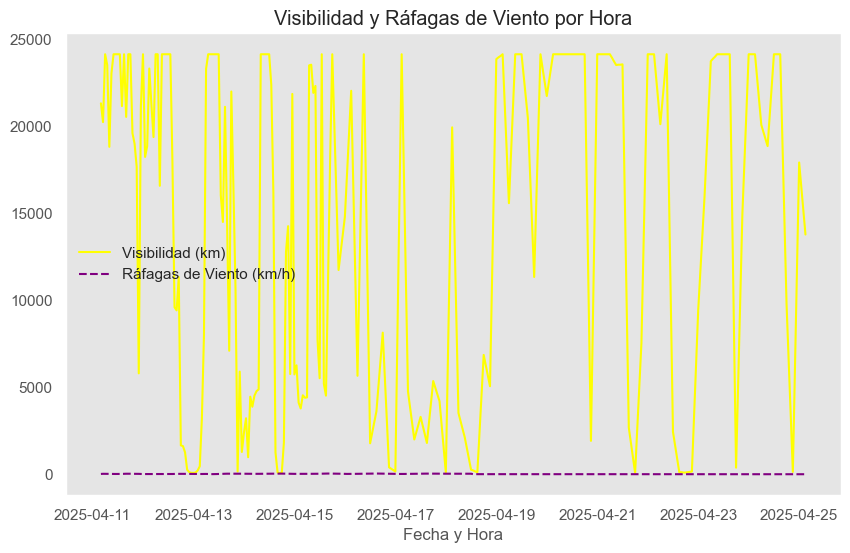

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(hourly_dataframe['date'], hourly_dataframe['visibility'], label="Visibilidad (km)", color='YELLOW')
plt.plot(hourly_dataframe['date'], hourly_dataframe['wind_gusts_10m'], label="Ráfagas de Viento (km/h)", color='purple', linestyle='--')
plt.xlabel("Fecha y Hora")
plt.title("Visibilidad y Ráfagas de Viento por Hora")
plt.legend()
plt.grid()
plt.show()
#Visibilidad: Si la visibilidad disminuye (línea amarilla baja), podría ser debido a condiciones meteorológicas como lluvia intensa, niebla o fuertes vientos.
#Impacto de las ráfagas: Si las ráfagas de viento (línea morada) coinciden con períodos de baja visibilidad, puede decirse que el viento contribuye a condiciones adversas (tormentas o levantamiento de polvo).


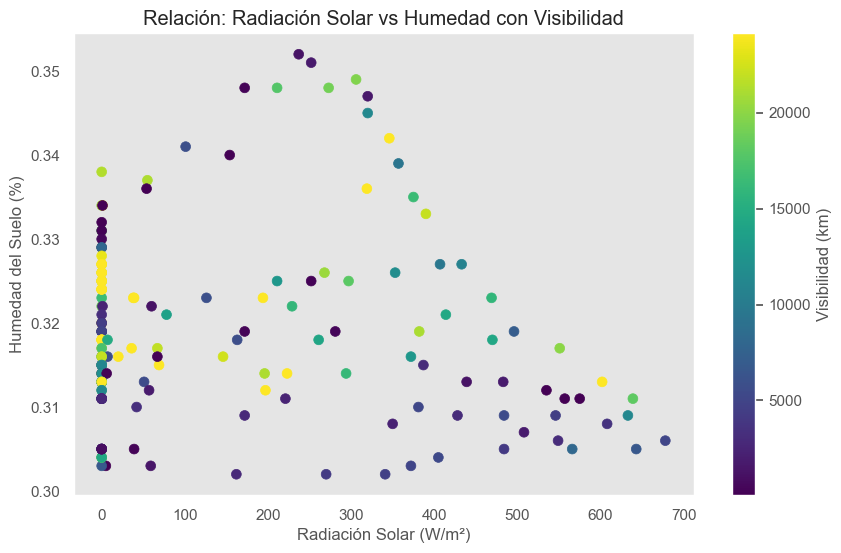

In [ ]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(hourly_dataframe['shortwave_radiation'], hourly_dataframe['soil_moisture_1_to_3cm'],
                 c=hourly_dataframe['visibility'], cmap='viridis', s=50)
plt.colorbar(label="Visibilidad (km)")
plt.xlabel("Radiación Solar (W/m²)")
plt.ylabel("Humedad del Suelo (%)")
plt.title("Relación: Radiación Solar vs Humedad con Visibilidad")
plt.grid()
plt.show()
#Si los puntos de colores más claros (son los de alta visibilidad) se concentran en zonas de alta radiación solar y baja humedad del suelo, esto podría indicar que los días despejados suelen estar relacionados con suelo seco y soleado.

#Si los puntos más oscuros (baja visibilidad) aparecen junto con baja radiación solar y alta humedad, esto podría indicar condiciones como lluvias o niebla.